In [2]:
%load_ext autoreload
%autoreload 2
import math
import os

import alphashape
import bento
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import seaborn as sns
import tifffile
from anndata import AnnData
from cellpose import models
from ClusterMap.clustermap import *
from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon
from skimage.measure import regionprops
from tqdm.auto import tqdm

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Processing Overview

Ingesting the raw Molecular Cartography data into Bento requires several pre-processing steps:<br />
1. Segment nuclei from DAPI images using CellPose<br />
2. Impute cell boundaries from RNA coordinates using ClusterMap<br />
3. Use Bento's I/O preprocessing function to clean the dataset and format into an AnnData<br />
4. (Optional) Save the AnnData as an h5ad file for downstream use by Bento or Scanpy

# Nuclei Segmentation

### Load DAPI Images

In [5]:
datadir = os.getcwd() # change to data path
files = os.listdir(datadir)
all_dapis = []
for f in files:
    if "DAPI" in f:
        all_dapis.append(f)

In [7]:
def load_raw(file):
    img = tifffile.imread(file)
    return img

Visualize a small subsection of the tiled DAPI image as a sanity check

In [15]:
test = load_raw(all_dapis[0])[0:1000, 0:1000]

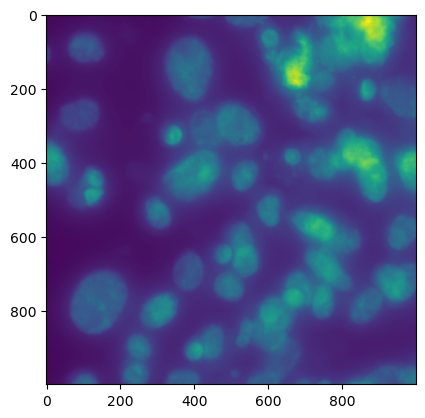

In [16]:
plt.imshow(test)

Define CellPose model to use. Here we use the pre-trained "nuclei" model

In [10]:
def cellpose(img, min_size=15):
    model = models.Cellpose(model_type="nuclei")
    res, _, _, _ = model.eval(
        img,
        channels=[0, 0],
        diameter=None,
        min_size=min_size,
    )
    return res

In [17]:
segs = cellpose(test)

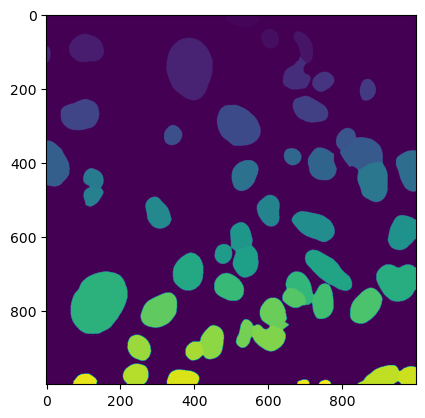

In [18]:
plt.imshow(segs)

### Segment and save binarized images of all DAPI files

In [ ]:
for f in tqdm(all_dapis):
    im = load_raw(f)
    segs = cellpose(im)
    filename = f.split(".tiff")[0] + "-cellpose.tiff"
    tifffile.imsave(filename, segs)

  0%|                                                                                                              | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_54778/1294642576.py:5: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(filename, segs)
 38%|████████████████████████████████████                                                            | 3/8 [2:29:35<4:12:16, 3027.37s/it]

# Cell Boundary Imputation

### Instantiate ClusterMap model

In [ ]:
def process_tile(data):
    ### set radius parameters
    pct_filter = 0
    xy_radius = 90
    # z_radius=7
    tile_num = data[0]
    out_ = data[1]
    spots_tile = out_.loc[tile_num, "spots"]
    dapi_tile = out_.loc[tile_num, "img"]
    g_list = data[2]
    n_dims = data[3]
    model_tile = ClusterMap(
        spots=spots_tile,
        dapi=dapi_tile,
        gene_list=g_list,
        num_dims=n_dims,
        xy_radius=xy_radius,
        z_radius=0,
        fast_preprocess=False,
    )
    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3, pct_filter=pct_filter)

    # ### segmentation
    model_tile.min_spot_per_cell = 5
    model_tile.segmentation(
        cell_num_threshold=0.07,
        dapi_grid_interval=3,
        add_dapi=True,
        use_genedis=True,
    )
    return model_tile

In [ ]:
# specify wells to run on
all_wells = [
    "32786-slide5_A1-1_",
    "32786-slide5_A2-1_",
    "32786-slide5_B1-1_",
    "32786-slide5_B2-1_",
    "32786-slide5_C1-1_",
    "32786-slide5_C2-1_",
    "32786-slide5_D1-1_",
    "32786-slide5_D2-1_",
]

In [ ]:
for well in all_wells:
    # Repeat for the whole dataset
    file_string = well

    # read DAPI
    dapi = tifffile.imread(file_string + "DAPI.tiff")

    # read spots
    raw_spots = pd.read_csv(file_string + "results.txt", sep="\t", header=None)
    raw_spots = raw_spots.rename(
        columns={
            0: "spot_location_1",
            1: "spot_location_2",
            2: "spot_location_3",
            3: "gene_name",
        }
    )
    spots = raw_spots.drop(
        columns=[4]
    )  # we weren't provided with 3D nuclei so no point in burning resources doing 3D segmentation
    # give genes a numerical index...ClusterMap requires it
    genes = list(np.unique(spots["gene_name"]))
    gene = []
    for g in tqdm(spots["gene_name"].to_list()):
        gene.append(genes.index(g))
    spots["gene"] = gene
    ### trim
    img = dapi
    window_size = 1000  # ClusterMap is memory intensive, so it will run tiled on your whole dataset
    label_img = get_img(
        img,
        spots,
        window_size=window_size,
        margin=math.ceil(window_size * 0.1),
    )
    out = split(
        img,
        label_img,
        spots,
        window_size=window_size,
        margin=math.ceil(window_size * 0.1),
    )
    ### set radius parameters
    xy_radius = 90  # approximate radius of a single cell
    pct_filter = 0
    num_gene = np.max(spots["gene"])
    gene_list = np.arange(1, num_gene + 1)
    num_dims = len(dapi.shape)
    model = ClusterMap(
        spots=spots,
        dapi=dapi,
        gene_list=gene_list,
        num_dims=num_dims,
        xy_radius=xy_radius,
        z_radius=0,
        fast_preprocess=True,
    )
    model.spots["clustermap"] = -1

    for tile_num in range(out.shape[0]):
        data = [tile_num, out, gene_list, num_dims]
        print(f"tile: {tile_num}")
        spots_tile = out.loc[tile_num, "spots"]
        dapi_tile = out.loc[tile_num, "img"]
        model_tile = ClusterMap(
            spots=spots_tile,
            dapi=dapi_tile,
            gene_list=gene_list,
            num_dims=num_dims,
            xy_radius=xy_radius,
            z_radius=0,
            fast_preprocess=False,
        )
        model_tile.preprocess(dapi_grid_interval=3, pct_filter=pct_filter)
        model_tile.min_spot_per_cell = 5
        model_tile.segmentation(
            cell_num_threshold=0.1,
            dapi_grid_interval=3,
            add_dapi=True,
            use_genedis=True,
        )
        model.stitch(model_tile, out, tile_num)

    model.plot_segmentation(
        figsize=(30, 15),
        s=0.05,
        plot_with_dapi=False,
        plot_dapi=True,
        show=False,
    )
    plt.show()
    path_save = file_string + "ClustMap_assigned.csv"
    model.save_segmentation(path_save)

# Ingest boundaries and molecular coordinates into Bento

In [ ]:
save_dir = "Re-processed-11082022/"  # folder where all of the prior result files are stored

In [ ]:
def _alphashape_poly_generate(molecules, x_label="x", y_label="y", alpha=0.05):
    points = np.array([molecules[x_label], molecules[y_label]]).T
    poly = alphashape.alphashape(points, alpha).buffer(0)
    poly = (
        poly.buffer(5).buffer(-5).buffer(0)
    )  # get rid of weird self-intersections


def read_clustermap(
    clustermap_path,
    nuclear_path,
    save_name=None,
):
    """Prepare AnnData from ClusterMap files.

    Parameters
    ----------
    clustermap_path : String
        Path to clustermap results.
    nuclear_path : String
        path to nuclear segmentations as a labelled 2D numpy array where 1st and 2nd dimensions
        correspond to x and y, and pixel value are labels for each unique nuclei.
    save_name : String
        Optional; path to save anndata object
    Returns
    -------
        AnnData object
    """
    clustermap_results = pd.read_csv(clustermap_path)
    nuc_segs = cv2.imread(nuclear_path, -1)
    props = regionprops(nuc_segs)
    nuc_polys = []
    print("Converting nuclei to polygons")
    for prop in tqdm(props):
        nuc_poly = Polygon(prop.coords)
        nuc_polys.append(nuc_poly)
    nuc_gdf = gpd.GeoDataFrame(geometry=nuc_polys)
    cell_polys = []
    print("Converting clustermap results to alphashape polygons")
    cell_idxs = list(np.unique(clustermap_results["clustermap"]))

    for cell in tqdm(
        cell_idxs[1:]
    ):  # ignore -1 label as that means unclustered
        df = clustermap_results[clustermap_results["clustermap"] == cell]
        cell_poly = _alphashape_poly_generate(
            df, x_label="spot_location_1", y_label="spot_location_2"
        )
        cell_polys.append(cell_poly)
    cell_gdf = gpd.GeoDataFrame(geometry=cell_polys)
    adata = prepare(
        clustermap_results,
        cell_seg=cell_gdf,
        x="spot_location_1",
        y="spot_location_2",
        gene="gene_name",
        other_seg=dict(nucleus=nuc_gdf),
    )
    if save_name is not None:
        write_h5ad(adata, save_name)

In [ ]:
data_path = os.getcwd()
for well in tqdm(all_wells):
    data = read_clustermap(
        clustermap_path=data_path + well + "ClustMap_assigned.csv",
        nuclear_path=data_path + well + "_DAPI-cellpose.tiff",
        save_name=save_dir
        + well,  # set file name to save Bento AnnData database for future use
    )